In [10]:
from multiprocess import Pool
import numpy as np
import time

def do_all(input):
    from kniffel_forimport import run_game
    return run_game(printscoreboard=False)

if __name__ == '__main__':
    start_time = time.time()
    n = 1000
    scores = []
    iterations = [1 for _ in range(n)]
    p = Pool()
    scores = p.map(do_all, iterations)
    p.close()
    p.join()

    stop_time = time.time()
    total_time = stop_time - start_time
    hours = int(total_time // 3600)
    minutes = int((total_time % 3600) // 60)
    seconds = int(total_time % 60)
    print("Total time:", f"{hours:02d}:{minutes:02d}:{seconds:02d}")
    print("Average score:", np.mean(scores))
    print("Highest score:", np.max(scores))
    print("Lowest score:", np.min(scores))
    print("Samples:", len(scores))
    print("Samples per second:", np.round(len(scores) / total_time, 2))

Total time: 00:02:45
Average score: 250.315
Highest score: 449
Lowest score: 144
Samples: 1000
Samples per second: 6.05


In [ ]:
import matplotlib.pyplot as plt

plt.hist(scores, bins=389, density=True) # 63, 84, 126, 251
plt.xlabel('Sum')
plt.ylabel('Normalized Frequency')
plt.title('1000 Samples (one kniffel, avg 248.8)')
plt.show()

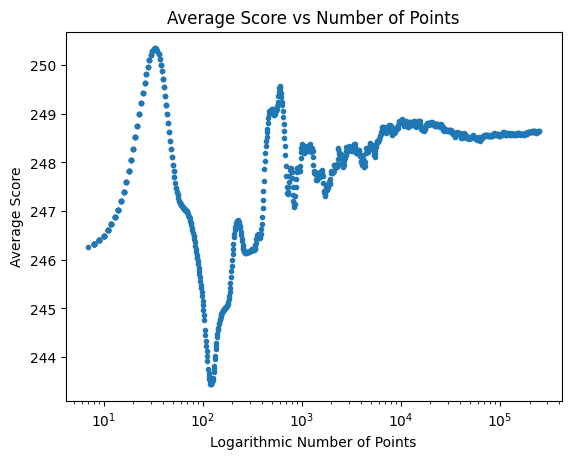

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


# Load the file content
file_path = r"C:\Users\paulk\Documents\Programmieren\Python\Kniffel\saves\250000samples_30012024\scores.txt"
with open(file_path, 'r') as file:
    file_content = file.read()

# Convert the file content to a numpy array and filter it
filtered_numbers = np.fromstring(file_content, sep='\n')
# minimum, maximum = 200, 320
# filtered_numbers = [num for num in sums if num >= minimum and num <= maximum]
# Apply Gaussian filter to the numbers in sums
filtered_numbers = gaussian_filter(filtered_numbers, sigma=10)
# filtered_numbers = filtered_numbers[:2000]


# Calculate the logarithmic number of points
numbers = np.floor(np.logspace(0.9, np.log10(len(filtered_numbers)), num=1000, base=10))

# Calculate the average score
avg_list = []
for number in numbers:
    avg_list.append(np.mean(filtered_numbers[-int(number):]))

# Plot the average score over the logarithmic number of points
plt.plot(numbers, avg_list, '.')
plt.xlabel('Logarithmic Number of Points')
plt.ylabel('Average Score')
plt.title('Average Score vs Number of Points')
plt.xscale('log')
plt.show()


In [5]:
def main():
    import cProfile
    import pstats
    from kniffel_forimport import run_game

    with cProfile.Profile() as pr:
        run_game()

    stats = pstats.Stats(pr)
    stats.sort_stats(pstats.SortKey.TIME)
    stats.print_stats()

if __name__ == '__main__':
    main()

Name    	 Test
Ones    	 2
Twos    	 8
Threes  	 3
Fours   	 8
Fives   	 10
Sixes   	 12
Sum     	 43
Bonus   	 0
Total 1 	 43
One pair	 12
Two pairs	 20
Triple  	 18
Quadruple	 0
Full house	 30
Small straigth	 25
Big straight	 40
Kniffel 	 0
Chance  	 25
Total 2 	 170
Total   	 213
         2323252 function calls in 4.066 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   292974    1.121    0.000    1.121    0.000 {method 'index' of 'list' objects}
       30    0.712    0.024    1.936    0.065 c:\Users\paulk\Documents\Programmieren\Python\Kniffel\kniffel_forimport.py:218(get_reroll_state_propability)
       30    0.478    0.016    4.061    0.135 c:\Users\paulk\Documents\Programmieren\Python\Kniffel\kniffel_forimport.py:249(collect_decision_parameters)
   288771    0.383    0.000    1.330    0.000 c:\Users\paulk\Documents\Programmieren\Python\Kniffel\kniffel_forimport.py:162(calc_score_field)
   288771    0.295    0.000    

<function matplotlib.pyplot.show(close=None, block=None)>

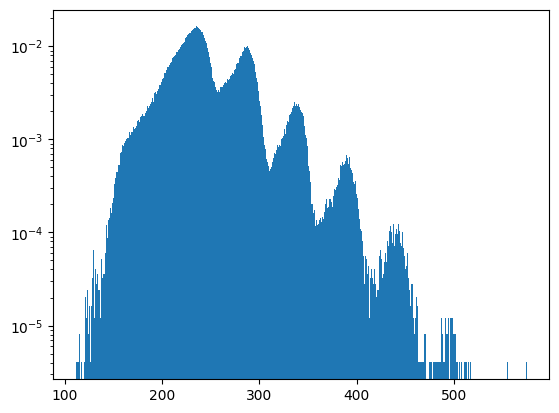

In [7]:
import numpy as np
import matplotlib.pyplot as plt
file_path = r"C:\Users\paulk\Documents\Programmieren\Python\Kniffel\saves\250000samples_30012024\scores.txt"
file_content = np.loadtxt(file_path)

plt.hist(file_content, bins=465, density=True) # 63, 84, 126, 251
plt.yscale('log')
plt.show


In [64]:
import numpy as np
from numba import jit
from itertools import combinations

@jit(nopython=True)
def find_first_index(arr1, arr2):
    for i, row in enumerate(arr2):
        if np.array_equal(arr1, row):
            return i

@jit(nopython=True)
def get_combinations_numba(state):
    # Get all rerolls of the state
    rerolls = np.zeros((32, 5), dtype=np.uint8)
    counts = np.zeros((32, 6), dtype=np.uint8)
    unique_count_indices = np.zeros((1), dtype=np.uint8)
    for index in range(32):
        rerolls[index] = state
        for i in range(5): # create the rerolls including duplicates
            if index & (1 << i):
                rerolls[index, i] = 0
        for roll in rerolls[index]: # create the counts of the rerolls
            if roll != 0:
                counts[index, roll-1] += 1    
        if find_first_index(counts[index], counts) not in unique_count_indices:
            unique_count_indices = np.append(unique_count_indices, np.array([find_first_index(counts[index], counts)]))
    unique_counts = counts[unique_count_indices]
    unique_rerolls = np.zeros((len(unique_counts), 5), dtype=np.uint8)   
    for reroll_index in range(len(unique_rerolls)):
        index = 0
        for k, count in enumerate(unique_counts[reroll_index]):
            if count > 0:
                for j in range(count):
                    unique_rerolls[reroll_index, index] = k + 1
                    index += 1
    return np.array(unique_rerolls)

test = get_combinations_numba(np.array([1, 2, 3, 4, 5]))
test

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(list(OptionalType(int64))<iv=None>)
 
There are 2 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload in function 'impl_np_array': File: numba\np\arrayobj.py: Line 5384.
        With argument(s): '(list(OptionalType(int64))<iv=None>)':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: Failed in nopython mode pipeline (step: nopython frontend)
       [1m[1m[1mNo implementation of function Function(<intrinsic np_array>) found for signature:
        
        >>> np_array(list(OptionalType(int64))<iv=None>, none)
        
       There are 2 candidate implementations:
       [1m      - Of which 2 did not match due to:
             Intrinsic in function 'np_array': File: numba\np\arrayobj.py: Line 5358.
               With argument(s): '(list(OptionalType(int64))<iv=None>, none)':[0m
       [1m       Rejected as the implementation raised a specific error:
                NumbaNotImplementedError: [1mOptionalType(int64) cannot be represented as a NumPy dtype[0m[0m
         raised from c:\Users\paulk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\np\numpy_support.py:159
       [0m
       [0m[1mDuring: resolving callee type: Function(<intrinsic np_array>)[0m
       [0m[1mDuring: typing of call at c:\Users\paulk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\np\arrayobj.py (5395)
       [0m
       [1m
       File "..\..\..\..\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\np\arrayobj.py", line 5395:[0m
       [1m    def impl(object, dtype=None):
       [1m        return np_array(object, dtype)
       [0m        [1m^[0m[0m
[0m
  raised from c:\Users\paulk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\typeinfer.py:1086
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function array>)[0m
[0m[1mDuring: typing of call at C:\Users\paulk\AppData\Local\Temp\ipykernel_14168\2036823601.py (26)
[0m
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_14168\2036823601.py", line 26:[0m
[1m<source missing, REPL/exec in use?>[0m


In [249]:
import numpy as np
from numba import jit
from itertools import combinations_with_replacement
import random


@jit(nopython=True)
def calc_score_1_to_6(values, field):
    # Calculate the score for scoreboard indices 1 to 6: ones till sixes
    return np.sum(values[values == field])


@jit(nopython=True)
def calc_score_10(values):
    # Calculate the score for scoreboard index 10: one pair
    counts = np.zeros(6, dtype=np.uint8)
    for value in values:
        counts[value - 1] += 1
    max_value = 0
    for index in range(6):
        if counts[index] >= 2 and index + 1 > max_value:
            max_value = index + 1
    return 2 * max_value


@jit(nopython=True)
def calc_score_11(values):
    # Calculate the score for scoreboard index 11: two pairs
    counts = np.zeros(6, dtype=np.uint8)
    for value in values:
        counts[value - 1] += 1
    pairs = []
    for index in range(6):
        if counts[index] >= 2:
            pairs.append(index + 1)
    if len(pairs) == 2:
        return sum(pairs) * 2
    else:
        return 0


@jit(nopython=True)
def calc_score_12(values):
    # Calculate the score for scoreboard index 12: three of a kind
    counts = np.zeros(6, dtype=np.uint8)
    for value in values:
        counts[value - 1] += 1
    for i in range(6):
        if counts[i] >= 3:
            return (i + 1) * 3
    return 0


@jit(nopython=True)
def calc_score_13(values):
    # Calculate the score for scoreboard index 13: four of a kind
    counts = np.zeros(6, dtype=np.uint8)
    for value in values:
        counts[value - 1] += 1
    for i in range(6):
        if counts[i] >= 4:
            return (i + 1) * 4
    return 0


@jit(nopython=True)
def calc_score_14(values):
    # Calculate the score for scoreboard index 14: full house
    counts = np.zeros(6, dtype=np.uint8)
    for value in values:
        counts[value - 1] += 1
    if 3 in counts and 2 in counts:
        return 30
    return 0


@jit(nopython=True)
def calc_score_15(values):
    # Calculate the score for scoreboard index 16: small straight
    valid_values = np.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6]])
    for group in valid_values:
        count = 0
        for element in group:
            if element in values:
                count += 1
        if count == 4:
            return 25
    return 0


@jit(nopython=True)
def calc_score_16(values):
    # Calculate the score for scoreboard index 16: big straight
    valid_values = np.array([[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]])
    for group in valid_values:
        count = 0
        for element in group:
            if element in values:
                count += 1
        if count == 5:
            return 40
    return 0


@jit(nopython=True)
def calc_score_17(values):
    # Calculate the score for scoreboard index 17: kniffel
    counts = np.zeros(6, dtype=np.uint8)
    for value in values:
        counts[value - 1] += 1
    if 5 in counts:
        return 50
    return 0


@jit(nopython=True)
def calc_score_18(values):
    # Calculate the score for scoreboard index 18: chance
    return np.sum(values)


@jit(nopython=True)
def calc_score_field(values, field):
    # Calculate the score for the given values and field
    match field:
        case 1:  # Ones
            return calc_score_1_to_6(values, 1)
        case 2:  # Twos
            return calc_score_1_to_6(values, 2)
        case 3:  # Threes
            return calc_score_1_to_6(values, 3)
        case 4:  # Fours
            return calc_score_1_to_6(values, 4)
        case 5:  # Fives
            return calc_score_1_to_6(values, 5)
        case 6:  # Sixes
            return calc_score_1_to_6(values, 6)
        case 10:  # One pair
            return calc_score_10(values)
        case 11:  # Two pairs
            return calc_score_11(values)
        case 12:  # Three of a kind
            return calc_score_12(values)
        case 13:  # Four of a kind
            return calc_score_13(values)
        case 14:  # Full house
            return calc_score_14(values)
        case 15:  # Small straight
            return calc_score_15(values)
        case 16:  # Big straight
            return calc_score_16(values)
        case 17:  # Kniffel
            return calc_score_17(values)
        case 18:  # Chance
            return calc_score_18(values)
        

@jit(nopython=True)
def get_rerolls(state):
    # Get all rerolls of the state
    state_count = np.zeros((6), dtype=np.uint8)
    for roll in state: # Get the counts of the state
        state_count[roll-1] += 1 
    # Initialize
    reroll_counts = np.zeros((1, 6), dtype=np.uint8) 
    append_count = np.zeros(6, dtype=np.uint8)
    indices = np.where(state_count > 0)[0]
    limits = state_count[indices]
    append_count = np.zeros(6, dtype=np.uint8)
    current_index = 0
    max_index = 0
    while np.array_equal(append_count, state_count) == False:
        # Generate all unique reroll counts
        append_count[indices[current_index]] += 1
        for i,index in enumerate(indices):
            if append_count[index] > limits[i]:
                append_count[:index + 1] = 0
                append_count[indices[i + 1]] += 1
                current_index = 0
        if current_index == max_index:
            max_index += 1
            current_index = 0
        reroll_counts = np.concatenate((reroll_counts, append_count.reshape(1, -1)), axis=0) 
    # This below is really scuffed, but it works - look again for better performance
    rerolls = np.zeros((len(reroll_counts), 5), dtype=np.uint8)
    for i, reroll_count in enumerate(reroll_counts):
        state = []
        for j, count in enumerate(reroll_count):
            state.extend([j+1] * count)
        rerolls[i, :len(state)] = np.array(state, dtype=np.uint8)
    return rerolls

def get_states(n=5, k=6):
    # Calculate possible states of n dice with k sides
    states = np.empty((252, 5), dtype=np.uint8)
    dice = range(1, k + 1)
    for i, state in enumerate(combinations_with_replacement(dice, n)):
        states[i, :] = state
    return states

@jit(nopython=True)
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
    
@jit(nopython=True)
def unique_permutations(state):
    counts = np.zeros((6), dtype=np.uint8)
    for roll in state:
        counts[roll-1] += 1
    divider = 1
    for count in counts:
        if count > 1:
            divider *= factorial(count)
    return int(factorial(len(state)) / divider)

@jit(nopython=True)
def get_reroll_state_propability(state, rerolls, states, n=5, k=6):
    # Calculate propabilities for each state after rerolling
    propability = np.ones((len(rerolls), len(states)))
    propability[0, :] = 0
    for i, reroll in enumerate(rerolls[:-1]):
        # Reroll nothing
        if np.array_equal(reroll, np.array([0, 0, 0, 0, 0])):
            for j, s in enumerate(states):
                if np.array_equal(s, state):
                    propability[i, j] = 1
                    break
        else: # Reroll not all
            keep_dice = np.copy(state)
            for value in reroll:
                if value != 0:
                    remove_index = np.argwhere(keep_dice == value)[0]
                    keep_dice = np.delete(keep_dice, remove_index)
            for j, s in enumerate(states):
                reach_dice = np.copy(s)
                for element in keep_dice:
                    if element in reach_dice:
                        remove_index = np.argwhere(reach_dice == element)[0]
                        reach_dice = np.delete(reach_dice, remove_index)
                    else:
                        propability[i, j] = 0
                        break
                if propability[i, j] != 0:
                    propability[i, j] = (1 / k) ** len(reach_dice) * unique_permutations(reach_dice)
    # Reroll all
    for j, s in enumerate(states):
        propability[-1, j] = (1 / k) ** n * unique_permutations(s)
    return propability

@jit(nopython=True)
def calculate_potential(currentpoints, maxpoints, field, optimizer):
    # Calculate the potential points for the given field
    if field > 6:
        field = field - 3
    return currentpoints**2 / (maxpoints[field - 1] ** 1) * optimizer[field - 1]

@jit(nopython=True)
def find_best_score(freefields, roll, maxpoints, optimizer):
    # Find the best score for the given roll, output points and field
    current_points = np.zeros(len(freefields))
    potential_points = np.zeros(len(freefields))
    for i, field in enumerate(freefields):
        points = calc_score_field(roll, field)
        current_points[i] = points
        potential_points[i] += calculate_potential(points, maxpoints, field, optimizer)
    index = np.argmax(potential_points)
    return int(current_points[index]), freefields[index]

@jit(nopython=True)
def reroll_state(state, reroll_dice, n=5, k=6):
    for element in reroll_dice:
        remove_index = np.argwhere(state == element)[0]
        state[remove_index] = random.randint(1, k)
    return np.sort(state)

@jit(nopython=True)
def collect_decision_parameters(
    input_state, fields, maxpoints, optimizer, states, n=5, k=6
):
    # Collect decision parameters for the reroll decision
    rerolls = get_rerolls(input_state)
    print(rerolls)
    propabilities = get_reroll_state_propability(input_state, rerolls, states)
    print(propabilities)
    decision_score_matrix = np.zeros_like(propabilities)
    decision_score = np.zeros(len(rerolls))
    for i, reroll in enumerate(rerolls):
        for j, state in enumerate(states):
            if propabilities[i, j] != 0:
                potential_points = 0
                for field in fields:
                    currentpoints = calc_score_field(state, field)
                    potential_points += calculate_potential(
                        currentpoints, maxpoints, field, optimizer
                    )
                decision_score_matrix[i, j] = potential_points * propabilities[i, j]
        decision_score[i] = np.sum(decision_score_matrix[i, :])
    print(decision_score)
    index = np.argmax(decision_score)
    return rerolls[index]

input_state = np.array([1, 6, 6, 6, 6])
freefields = np.array([1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18])
maxpoints = np.array([5, 10, 15, 20, 25, 30, 12, 22, 18, 24, 30, 25, 40, 50, 30])
optimizer = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
states = get_states()

@jit(nopython=True)
def init():
    # Initialize scoreboard, textfields, freefields and decisionlists
    scoreboard = np.empty(20, dtype=np.int16)
    scoreboard[:] = -1
    textfields = np.array(
        [
            "Ones    ",
            "Twos    ",
            "Threes  ",
            "Fours   ",
            "Fives   ",
            "Sixes   ",
            "Sum     ",
            "Bonus   ",
            "Total 1 ",
            "One pair",
            "Two pairs",
            "Triple  ",
            "Quadruple",
            "Full house",
            "Small straight",
            "Big straight",
            "Kniffel ",
            "Chance  ",
            "Total 2 ",
            "Total   ",
        ],
        dtype=np.unicode_,
    )
    freefields = np.array(
        [1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18], dtype=np.uint8
    )
    maxpoints = np.array(
        [5, 10, 15, 20, 25, 30, 12, 22, 18, 24, 30, 25, 40, 50, 30], dtype=np.uint8
    )
    optimizer = np.array(
        [1, 1, 1, 1, 1, 1, 0.4, 0.8, 1, 1, 0.5, 0.4, 1, 1, 0.5], dtype=np.float32
    )
    return scoreboard, textfields, freefields, maxpoints, optimizer


kniffelindex = np.argwhere(freefields == 17)[0][0]
print(kniffelindex)
print(freefields[:kniffelindex])
writepoints, field = find_best_score(
    freefields[:kniffelindex] + freefields[kniffelindex + 1 :],
    np.array([1, 6, 6, 6, 6]),
    maxpoints,
    optimizer,
)

13
[ 1  2  3  4  5  6 10 11 12 13 14 15 16]


TypeError: expected int64, got None

In [1]:
from multiprocess import Pool
import numpy as np
import time
from kniffel_forimport_numba import get_states, run_game
import pstats
import cProfile

""" Command for shell:
    import os
    os.chdir("C:\\Users\\paulk\\Documents\\Programmieren\\Python\\Kniffel")
    exec(open('simulate_numba.py').read())
"""

start_time = time.time()


def runall(n, stime=start_time):
    scores = np.empty(n, dtype=int)
    all_states = get_states()
    print("Simulating", n, "Kniffel games using @jit...")
    for i in range(n):
        scores[i] = run_game(all_states)
        if i == 1:
            steptime1 = time.time()
        if i == 2:
            steptime2 = time.time()
    compiletime = steptime1 - stime - (steptime2 - steptime1)
    print("Compiletime:", np.round(compiletime, 2), "seconds")
    return scores, stime, compiletime


with cProfile.Profile() as pr:
    scores, start_time, compiletime = runall(100)
stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

stop_time = time.time()

total_time = stop_time - start_time
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)
print("Total time:", f"{hours:02d}:{minutes:02d}:{seconds:02d}")
print("Average score:", np.mean(scores))
print("Highest score:", np.max(scores))
print("Lowest score:", np.min(scores))
print("Samples:", len(scores))
print("Samples per second:", np.round(len(scores) / (total_time - compiletime), 2))

# scores = []

# all_states = get_states()
# with cProfile.Profile() as pr:

# stats = pstats.Stats(pr)
# stats.sort_stats(pstats.SortKey.TIME)
# stats.print_stats()


# def do_all(ins, states=all_states):
#     # Load kniffel functions and run the game
#     from kniffel_forimport_numba import run_game

#     return run_game(states)


# if __name__ == "__main__":
#     # Run the game in parallel
#     n = 1000
#     print("Simulating", n, "Kniffel games in parallel...")
#     start_time = time.time()
#     iterations = [1 for _ in range(n)]
#     p = Pool()
#     scores = p.map(do_all, iterations)
#     p.close()
#     p.join()

#     stop_time = time.time()
#     total_time = stop_time - start_time
#     hours = int(total_time // 3600)
#     minutes = int((total_time % 3600) // 60)
#     seconds = int(total_time % 60)
#     print("Total time:", f"{hours:02d}:{minutes:02d}:{seconds:02d}")
#     print("Average score:", np.mean(scores))
#     print("Highest score:", np.max(scores))
#     print("Lowest score:", np.min(scores))
#     print("Samples:", len(scores))
#     print("Samples per second:", np.round(len(scores) / total_time, 2))


Simulating 100 Kniffel games using @jit...
Compiletime: 26.6 seconds
         30026651 function calls (28322976 primitive calls) in 36.931 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100   10.432    0.104   10.432    0.104 c:\Users\paulk\Documents\Programmieren\Python\Kniffel\kniffel_forimport_numba.py:368(run_game)
    82369    9.320    0.000   11.256    0.000 c:\Users\paulk\AppData\Local\Programs\Python\Python311\Lib\site-packages\llvmlite\binding\ffi.py:188(__call__)
643973/116346    0.716    0.000    1.004    0.000 c:\Users\paulk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\ir.py:317(_rec_list_vars)
4226397/4226377    0.566    0.000    0.695    0.000 {built-in method builtins.isinstance}
   608406    0.419    0.000    1.091    0.000 c:\Users\paulk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\event.py:243(notify)
385721/198013    0.331    0.000    0.930    0.000 c